# Контекст

- Классификация фамилий по национальностям
- Национальность - метка (OneHot вектор)
- Векторизация фамилий:
    - Рассматривам фамилию как последовательность символов (кодируем их индексами из словаря)
    - Дополнительные токены UNK, MASK, BEGIN-OF-SEQUENCE и END-OF-SEQUENCE

# Особенности RNN Элмана

- добавление скрытого слоя (hidden layer) между входным и рекуррентным слоями
- обратная связь (feedback) передается не только в виде скрытого состояния в момент времени t, но также копируется и передается с задержкой на следующий момент времени t+1
- обладает внутренней памятью благодаря скрытому состоянию, которое сохраняет информацию о предыдущих состояниях сети


In [1]:
# база
import pandas as pd
import warnings
import numpy as np
import json
import time

# визуализация
import seaborn as sns
import matplotlib.pyplot as plt

# nltk
from nltk.lm import Vocabulary

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# метрика
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# константы
RANDOM_STATE = 42
warnings.filterwarnings("ignore")
path = 'surnames_with_splits.csv'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('CUDA ?: ', torch.cuda.is_available())

c:\Users\oudel\anaconda3\envs\newenv\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


CUDA ?:  True


In [2]:
data = pd.read_csv(path)
data.head()

,nationality,nationality_index,split,surname
0,Arabic,15,train,Totah
1,Arabic,15,train,Abboud
2,Arabic,15,train,Fakhoury
3,Arabic,15,train,Srour
4,Arabic,15,train,Sayegh


In [3]:
train = data[data['split'] == 'train']['nationality']
sorted(train.unique())

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

# Vocabulary

In [4]:
class SurnameVocabulary(object):
    def __init__(self, path):
        df = pd.read_csv(path)
        
        self.max_len = 0
        for surname in df['surname']:
               len_surname = len(surname)
               if len_surname > self.max_len:
                      self.max_len = len_surname

        df = df[df['split'] == 'train']
        self.nationality = df['nationality']
        self.surname= df['surname']


    def create_vocabs(self):
        # Surname словари
        all_tokens = list(''.join(self.surname))
        unique_tokens = set(all_tokens)
        count_tokens = pd.Series(all_tokens).value_counts().reset_index()
        rare_tokens = count_tokens[count_tokens['count'] == 1]
        rare_tokens = rare_tokens['index']
        unique_tokens_wot_rare = [token for token in list(unique_tokens) if token not in rare_tokens.to_list()]
        unique_tokens_wot_rare = sorted(unique_tokens_wot_rare)
        unique_tokens = ['<MASK>'] + unique_tokens_wot_rare + ['<BEGIN>', '<END>', '<UNK>']
        self.vocab_token_index = dict(zip(unique_tokens,
                                          [int(i) for i in np.arange(0, len(unique_tokens))]))
        self.vocab_index_token = {}
        for token, index in self.vocab_token_index.items():
            self.vocab_index_token[index] = token
        
        # Nationality словари
        self.nationality = sorted(self.nationality.unique())
        self.vocab_nationality_index = dict(zip(self.nationality,
                                                [int(i) for i in np.arange(0, len(self.nationality))]))
        self.vocab_index_nationality = {}
        for nationality, index in self.vocab_nationality_index.items():
            self.vocab_index_nationality[index] = nationality

        return self.vocab_token_index,\
               self.vocab_index_token,\
               self.vocab_nationality_index,\
               self.vocab_index_nationality
        
    def save_vocabs(self):
        with open('vocab_token_to_index.json', 'w') as file:
                    json.dump(self.vocab_token_index, file)
        with open('vocab_index_to_token.json', 'w') as file:
                    json.dump(self.vocab_index_token, file)
        with open('vocab_nationality_to_index.json', 'w') as file:
                    json.dump(self.vocab_nationality_index, file)
        with open('vocab_index_to_nationality.json', 'w') as file:
                    json.dump(self.vocab_index_nationality, file)
        print('Словари сохранены в открытой директории')

    def return_index(self, token):
           return self.vocab_token_index.get(token)
    
    def return_token(self, index):
           return self.vocab_token_index.get(index)
    
    def len_surname_vocab(self):
           return len(self.vocab_token_index)
    
    def len_nationality_vocab(self):
           return len(self.vocab_nationality_index)

Проверка работоспособности класса Vocabulary

In [5]:
vocabulary = SurnameVocabulary(path)
vocab_token_index,vocab_index_token,vocab_nationality_index, vocab_index_nationality =\
vocabulary.create_vocabs()
vocabulary.save_vocabs()

vocab_token_index

Словари сохранены в открытой директории


{'<MASK>': 0,
 "'": 1,
 '-': 2,
 '1': 3,
 'A': 4,
 'B': 5,
 'C': 6,
 'D': 7,
 'E': 8,
 'F': 9,
 'G': 10,
 'H': 11,
 'I': 12,
 'J': 13,
 'K': 14,
 'L': 15,
 'M': 16,
 'N': 17,
 'O': 18,
 'P': 19,
 'Q': 20,
 'R': 21,
 'S': 22,
 'T': 23,
 'U': 24,
 'V': 25,
 'W': 26,
 'X': 27,
 'Y': 28,
 'Z': 29,
 'a': 30,
 'b': 31,
 'c': 32,
 'd': 33,
 'e': 34,
 'f': 35,
 'g': 36,
 'h': 37,
 'i': 38,
 'j': 39,
 'k': 40,
 'l': 41,
 'm': 42,
 'n': 43,
 'o': 44,
 'p': 45,
 'q': 46,
 'r': 47,
 's': 48,
 't': 49,
 'u': 50,
 'v': 51,
 'w': 52,
 'x': 53,
 'y': 54,
 'z': 55,
 'ß': 56,
 'à': 57,
 'á': 58,
 'ä': 59,
 'è': 60,
 'é': 61,
 'í': 62,
 'ñ': 63,
 'ò': 64,
 'ó': 65,
 'ö': 66,
 'ú': 67,
 'ü': 68,
 'Ś': 69,
 '<BEGIN>': 70,
 '<END>': 71,
 '<UNK>': 72}

In [6]:
vocabulary.max_len

17

# Dataset

In [7]:
class SurnameDataset(Dataset):

    def __init__(self, path, mode):
        self.vocabulary = SurnameVocabulary(path)
        data = pd.read_csv(path)
        self.data = data[data['split'] == mode][['nationality', 'surname']]
        if mode == 'train':
            self.data = self.data.sample(frac = 1, random_state = RANDOM_STATE)
            self.vocab_token_index, self.vocab_index_token, self.vocab_nationality_index, self.vocab_index_nationality =\
            self.vocabulary.create_vocabs()
            self.vocabulary.save_vocabs()
        else:
            with open('vocab_token_to_index.json', 'r') as file:
                self.vocab_token_index = json.load(file)
            with open('vocab_index_to_token.json', 'r') as file:
                self.vocab_index_token = json.load(file)
            with open('vocab_nationality_to_index.json', 'r') as file:
                self.vocab_nationality_index = json.load(file)
            with open('vocab_index_to_nationality.json', 'r') as file:
                self.vocab_index_nationality = json.load(file)

        self.size_df = len(self.data)

    def __len__(self):
        return self.size_df

    def __getitem__(self, index):
        row = self.data.iloc[index]
        unk_index = self.vocab_token_index.get('<UNK>')
        surname = row['surname']
        surname = ['<BEGIN>'] + list(surname) + ['<END>']
        self.x_length = len(surname)
        self.matrix_surname = np.zeros(self.vocabulary.max_len + 2)
        for index, token in enumerate(surname):
            self.matrix_surname[index] = self.vocab_token_index.get(token, unk_index)

        nationality = row['nationality']
        self.one_hot_label = np.zeros(len(self.vocab_nationality_index))
        self.one_hot_label[self.vocab_nationality_index.get(nationality)] = 1

        return self.matrix_surname, self.one_hot_label,  self.x_length

Проверка работоспособности класса Dataset

- векторное представление фамилии (закодированные словарем фамилии [BEGIN - .... - END - MASK:])
- OneHot вектор длиной 17
- длина токенов фамилии + 2 доп токена BEGIN,END

In [8]:
train_dataloader = DataLoader(dataset = SurnameDataset(path, 'train'),
                              batch_size = 128)

train_dataloader.dataset[0]

Словари сохранены в открытой директории


(array([70., 28., 30., 37., 38., 43., 71.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0.]),
 7)

# Model

In [9]:
def column_gather(y_out, x_lengths):
    '''  
    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1
    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index, column_index])

    return torch.stack(out)

# Elman RNN layer

In [10]:
class ElmanRNN(nn.Module):

    def __init__(self, input_size, hidden_size, batch_first=False):
        """
        Args:
            input_size (int): размерность входного векторов
            hidden_size (int): размер скрытых векторов состояния
            bathc_first (bool): является ли 0-е измерение пакетным
        """
        super(ElmanRNN, self).__init__()
        
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        
        self.batch_first = batch_first
        self.hidden_size = hidden_size

    def _initial_hidden(self, batch_size):
        return torch.zeros((batch_size, self.hidden_size))

    def forward(self, x_in, initial_hidden=None):

        if self.batch_first:
            batch_size, seq_size, feat_size = x_in.size()
            x_in = x_in.permute(1, 0, 2)
        else:
            seq_size, batch_size, feat_size = x_in.size()
    
        hiddens = []

        if initial_hidden is None:
            initial_hidden = self._initial_hidden(batch_size)
            initial_hidden = initial_hidden.to(x_in.device)

        hidden_t = initial_hidden
                    
        for t in range(seq_size):
            hidden_t = self.rnn_cell(x_in[t], hidden_t)
            hiddens.append(hidden_t)
            
        hiddens = torch.stack(hiddens)

        if self.batch_first:
            hiddens = hiddens.permute(1, 0, 2)

        return hiddens


# Разбор каждого слоя будущей модели

# Входная матрица

In [11]:
x_in = np.zeros((128, 19))
y_in = np.zeros((128, 18))
lengths_list = []
for i in range(0, 128):
    values = train_dataloader.dataset[i][0]
    length = train_dataloader.dataset[i][2]
    label = train_dataloader.dataset[i][1]
    x_in[i] = values
    y_in[i] = label
    lengths_list.append(length)

x_in = torch.tensor(x_in, dtype = torch.int)
print(x_in.shape)
print('Длины последовательностей: \n', lengths_list)
x_in

torch.Size([128, 19])
Длины последовательностей: 
 [7, 12, 7, 8, 10, 7, 9, 6, 7, 7, 9, 8, 9, 11, 10, 8, 7, 9, 7, 8, 9, 9, 11, 12, 9, 8, 10, 12, 12, 9, 9, 11, 10, 6, 8, 9, 12, 14, 10, 12, 8, 10, 9, 8, 12, 10, 7, 8, 12, 6, 7, 9, 8, 9, 8, 10, 11, 7, 8, 9, 4, 7, 8, 5, 10, 7, 11, 11, 10, 8, 7, 7, 8, 14, 9, 8, 9, 8, 9, 7, 9, 7, 10, 7, 9, 8, 13, 8, 14, 8, 9, 9, 6, 6, 8, 7, 6, 9, 8, 7, 9, 9, 13, 10, 6, 8, 5, 11, 5, 9, 8, 11, 8, 6, 10, 9, 7, 11, 7, 12, 8, 8, 8, 9, 8, 7, 8, 10]


tensor([[70, 28, 30,  ...,  0,  0,  0],
        [70, 29, 44,  ...,  0,  0,  0],
        [70, 22, 42,  ...,  0,  0,  0],
        ...,
        [70,  6, 41,  ...,  0,  0,  0],
        [70, 23, 44,  ...,  0,  0,  0],
        [70,  4, 43,  ...,  0,  0,  0]], dtype=torch.int32)

In [12]:
y_in

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Слой Embedding

In [13]:
len(vocabulary.vocab_token_index)

73

In [14]:
emb = nn.Embedding(num_embeddings = len(vocabulary.vocab_token_index), # размер словаря
                   embedding_dim = 100, # 100
                   padding_idx = 0)

out_emb = emb(x_in)
print(out_emb.shape)
out_emb

torch.Size([128, 19, 100])


tensor([[[-0.6183, -1.5884, -1.0392,  ..., -1.1030, -0.0393,  0.1527],
         [-0.7616, -0.5478,  0.3870,  ..., -0.2456,  0.1404, -1.5680],
         [ 0.0570,  0.0890, -0.5031,  ..., -0.4187, -0.4123,  2.1059],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.6183, -1.5884, -1.0392,  ..., -1.1030, -0.0393,  0.1527],
         [ 0.5189,  1.8247,  0.7192,  ..., -0.6611, -0.2556,  0.2609],
         [ 0.4090, -1.2935,  0.7135,  ...,  1.6246, -1.8273, -0.5356],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.6183, -1.5884, -1.0392,  ..., -1.1030, -0.0393,  0.1527],
         [ 0.0448, -1.3136,  1.6929,  ..., -0

# ElmanRnn слой

In [15]:
rnn = ElmanRNN(input_size = 100,
               hidden_size = 64,
               batch_first = True)

out_rnn = rnn(out_emb)
print(out_rnn.shape)
out_rnn

torch.Size([128, 19, 64])


tensor([[[ 0.1920,  0.5886, -0.5963,  ..., -0.3982,  0.1624, -0.7647],
         [-0.1101,  0.6257, -0.1568,  ...,  0.1598,  0.1141, -0.5643],
         [ 0.0467, -0.3993,  0.3339,  ...,  0.8292,  0.6405,  0.6463],
         ...,
         [-0.1126, -0.0706, -0.1341,  ...,  0.1003, -0.0747, -0.0933],
         [-0.1121, -0.0670, -0.1352,  ...,  0.1018, -0.0736, -0.0977],
         [-0.1114, -0.0688, -0.1348,  ...,  0.1007, -0.0754, -0.0959]],

        [[ 0.1920,  0.5886, -0.5963,  ..., -0.3982,  0.1624, -0.7647],
         [-0.3223, -0.2159, -0.8142,  ...,  0.7852, -0.4426,  0.4326],
         [ 0.5191, -0.2968,  0.3101,  ...,  0.8463,  0.2125, -0.7063],
         ...,
         [-0.1290, -0.0776, -0.1636,  ...,  0.1740, -0.0638, -0.1051],
         [-0.1356, -0.0825, -0.1496,  ...,  0.1345, -0.0863, -0.0956],
         [-0.1079, -0.0623, -0.1410,  ...,  0.1163, -0.0722, -0.1120]],

        [[ 0.1920,  0.5886, -0.5963,  ..., -0.3982,  0.1624, -0.7647],
         [-0.5428,  0.0311,  0.1074,  ...,  0

# Последнее состояние (применяем индекс длины)

In [16]:
out_rnn_last =\
column_gather(y_out = out_rnn,
              x_lengths = torch.LongTensor(lengths_list))

print(out_rnn_last.shape)
out_rnn_last

torch.Size([128, 64])


tensor([[ 0.3721,  0.2843, -0.7481,  ...,  0.7198, -0.2845, -0.8740],
        [ 0.1455,  0.1285, -0.7990,  ...,  0.6206,  0.2654, -0.7812],
        [-0.0424,  0.1406, -0.8463,  ...,  0.6771,  0.1202, -0.7416],
        ...,
        [-0.0496, -0.0879, -0.7103,  ...,  0.9004, -0.3088, -0.4492],
        [-0.1807,  0.3992, -0.6980,  ...,  0.7308, -0.3931, -0.8681],
        [ 0.2134,  0.5819, -0.7618,  ...,  0.7622, -0.0230, -0.7894]],
       grad_fn=<StackBackward0>)

# 1-й Линейный слой 

In [17]:
fc1 = nn.Linear(in_features= 64,
                out_features = 64)
linear1_out = fc1(out_rnn_last)
print(linear1_out.shape)
linear1_out

torch.Size([128, 64])


tensor([[-0.5126, -0.1574,  0.0380,  ..., -0.1977,  0.2719, -0.0928],
        [-0.6000, -0.1352, -0.1005,  ..., -0.5226,  0.1457, -0.2857],
        [-0.6342, -0.1151, -0.0474,  ..., -0.4987,  0.1594, -0.2467],
        ...,
        [-0.6266,  0.0922,  0.0547,  ..., -0.5619,  0.5253, -0.0602],
        [-0.6588, -0.1603, -0.1085,  ..., -0.3617,  0.3856, -0.2046],
        [-0.5241,  0.0287,  0.0729,  ..., -0.4713,  0.3885, -0.1994]],
       grad_fn=<AddmmBackward0>)

# 2-й Линейный слой

In [18]:
fc2 = nn.Linear(in_features = 64,
                out_features = len(vocab_nationality_index))

linear2_out = fc2(linear1_out)
print(linear2_out.shape)
linear2_out

torch.Size([128, 18])


tensor([[-0.1848, -0.0061,  0.0118,  ...,  0.0990, -0.1034, -0.0978],
        [-0.1412,  0.1538, -0.0762,  ...,  0.1154,  0.0553, -0.1529],
        [-0.0206,  0.1698, -0.1178,  ...,  0.1310, -0.0766, -0.1146],
        ...,
        [-0.2716,  0.1901,  0.0108,  ...,  0.0843, -0.1081, -0.0970],
        [-0.1794,  0.1953,  0.1395,  ...,  0.1238, -0.0713, -0.0686],
        [-0.2164,  0.0986, -0.0678,  ...,  0.1497, -0.1501, -0.1889]],
       grad_fn=<AddmmBackward0>)

# Softmax

In [19]:
outputs = torch.softmax(linear2_out, dim = 1)
outputs

tensor([[0.0508, 0.0607, 0.0618,  ..., 0.0674, 0.0551, 0.0554],
        [0.0521, 0.0699, 0.0556,  ..., 0.0673, 0.0634, 0.0515],
        [0.0589, 0.0712, 0.0534,  ..., 0.0685, 0.0557, 0.0536],
        ...,
        [0.0446, 0.0707, 0.0591,  ..., 0.0636, 0.0525, 0.0531],
        [0.0494, 0.0718, 0.0679,  ..., 0.0668, 0.0550, 0.0551],
        [0.0486, 0.0667, 0.0564,  ..., 0.0702, 0.0520, 0.0500]],
       grad_fn=<SoftmaxBackward0>)

In [20]:
_ , predict_labels = torch.max(outputs,1)
predict_labels

tensor([ 8,  8,  8, 13, 13,  8,  8,  8,  8,  8,  8,  8,  8, 13,  8,  8,  8,  8,
         8, 13,  8, 13,  8,  8, 13,  8,  8,  8,  8,  8, 13,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8, 13, 13,  8, 13,  8,  8,  8,  8, 13,
         8,  8,  8,  8, 13,  8, 13,  8,  8, 13,  8, 13,  8,  8,  8,  8,  8,  8,
        13,  8,  8, 13,  8, 13,  8,  8, 13,  8,  8,  8,  8, 13,  8, 13,  8,  8,
        13,  8,  8,  8,  8,  8,  8,  8, 15, 13,  8,  8, 13, 13, 13,  8, 13, 13,
        13, 13, 13,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        13,  8])

In [21]:
true_labels = torch.argmax(torch.tensor(y_in), dim = 1)
correct_train_acc = (predict_labels == true_labels).sum().item()
correct_train_acc

1

In [22]:
torch.tensor(y_in).size(0)

128

# Classifier

In [23]:
class SurnameClassifier(nn.Module):
    """ A Classifier with an RNN to extract features and an MLP to classify """
    def __init__(self, embedding_dim, num_embeddings, num_classes,
                 rnn_hidden_size, batch_first=True, padding_idx=0):
        """
        Args:
            embedding_dim (int): размер вложений символов
            num_embeddings (int): размер словаря
            num_classes (int): кол-во национальностей
            rnn_hidden_size (int): размер скрытого состояния
            batch_first (bool): есть ли нулевое измерение (измерение пакета)
            padding_idx (int): индекс заполнения тензора
        """
        super(SurnameClassifier, self).__init__()

        self.emb = nn.Embedding(num_embeddings=num_embeddings, # размер словаря
                                embedding_dim=embedding_dim, # 100
                                padding_idx=padding_idx)
        self.rnn = ElmanRNN(input_size=embedding_dim,
                             hidden_size=rnn_hidden_size,
                             batch_first=batch_first)
        self.fc1 = nn.Linear(in_features=rnn_hidden_size,
                             out_features=rnn_hidden_size)
        self.fc2 = nn.Linear(in_features=rnn_hidden_size,
                             out_features=num_classes)

    def forward(self, x_in, x_lengths=None):

        x_embedded = self.emb(x_in)
        y_out = self.rnn(x_embedded)

        if x_lengths is not None:
            y_out = column_gather(y_out, x_lengths) # вывод последнего состояния сети
        else:
            y_out = y_out[:, -1, :]

        y_out = F.relu(self.fc1(F.dropout(y_out, 0.5)))
        y_out = self.fc2(F.dropout(y_out, 0.5))

        return y_out

# Функция L1_L2 регуляризации

In [24]:
def loss_with_l1_or_l2_regulizer(
        
        model,
        type, # Здесь могут быть 3 вида : 'l1', 'l2', 'l1_l2' 
        l_lambda, # 0.001
        loss_by_fn):
    
    if type == 'l2':
        l_norm = sum(p.pow(2.0).sum() for p in model.parameters())

    if type == 'l1':
        l_norm = sum(p.abs().sum() for p in model.parameters())

    if type == 'l1_l2':
        l_norm = sum((p.abs() + p.pow(2.0)).sum() for p in model.parameters())
    
    loss_plus_reg = loss_by_fn + l_lambda * l_norm
    return loss_plus_reg

# Training loop

In [25]:
def training_loop(
        epoches,
        model,
        optimizer,
        scheduler_append,
        scheduler,
        loss_fn,
        train_dataloader,
        val_dataloader,

        # regulizer
        regulizer,
        reg_type,
        
        # stop settings
        stop_mode,
        each__X__epoch,
        stop_diff_value,

        # verbose
        verbose_epoch
        ):
    
    loss_train_list = []
    loss_val_list = []
    acc_train_list = []
    acc_val_list = []

    model = model.to(device)
    for epoch in range(1, epoches+1):
            
            start_time = time.time()
            loss_train = 0
            loss_val = 0

            correct_train_acc = 0
            correct_val_acc = 0
            total_train_acc = 0
            total_val_acc = 0
            
            for features, labels, _ in train_dataloader:
                
                model.train()
                features = features.type(torch.LongTensor).to(device)
                labels = labels.to(device)
                outputs = model(features)

                # Тренировочный потери
                loss = loss_fn(outputs, labels)
                
                if regulizer:
                        loss = loss_with_l1_or_l2_regulizer(model = model,
                                                            type = reg_type,
                                                            l_lambda = 0.001,
                                                            loss_by_fn = loss)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                loss_train += loss.item()
                
                ########  Расчет тренировочной accuracy  #########
                outputs = torch.softmax(outputs, dim = 1)
                _ , predict_labels = torch.max(outputs,1)
                total_train_acc += labels.size(0)
                # correct_train_acc += (predict_labels == labels).sum().item()
                true_labels = torch.argmax(labels, dim = 1)
                correct_train_acc += (predict_labels == true_labels).sum().item()
                ##################################################

            mean_epoch_loss = loss_train/len(train_dataloader)
            loss_train_list.append(mean_epoch_loss)
            train_acc = correct_train_acc / total_train_acc
            acc_train_list.append(train_acc)
            # Проверочный этап
            model.eval()
            with torch.no_grad():
                                for features, labels, _ in val_dataloader:
                                        features = features.type(torch.LongTensor).to(device)
                                        labels = labels.to(device)
                                        outputs = model(features)
                                        loss_on_val = loss_fn(outputs, labels)
                                        loss_val += loss_on_val.item()
                                        
                                        ########  Расчет валидационной accuracy  #########
                                        outputs = torch.softmax(outputs, dim = 1)
                                        _ , predict_labels = torch.max(outputs,1)
                                        total_val_acc += labels.size(0)
                                        # correct_train_acc += (predict_labels == labels).sum().item()
                                        true_labels = torch.argmax(labels, dim = 1)
                                        correct_val_acc += (predict_labels == true_labels).sum().item()
                                        ##################################################

                                mean_epoch_loss_val = loss_val / len(val_dataloader)
                                loss_val_list.append(mean_epoch_loss_val)
                                val_acc = correct_val_acc / total_val_acc
                                acc_val_list.append(val_acc)
                                
            # EARLY STOPPING #######################################
            if stop_mode:
                if len(loss_train_list) >= each__X__epoch:
                        past = loss_train_list[-each__X__epoch]
                        now = loss_train_list[-1]
                        if (past <= now):

                                print('________________________Ранняя остановка (тренировочные проблемы)_________________________________________________')
                                print('На {} эпохе пришлось остановить обучение'.format(epoch))
                                print('loss_{}_эпохи >= loss_{}_эпохи'.format(epoch,
                                                                              epoch - each__X__epoch))
                                break
                        if (past - now) < stop_diff_value:
                                print('________________________Ранняя остановка (тренировочные проблемы)_________________________________________________')
                                print('На {} эпохе пришлось остановить обучение'.format(epoch))
                                print('loss_{}_эпохи - loss_{}_эпохи < {}'.format(epoch - each__X__epoch,
                                                                                  epoch,
                                                                                  stop_diff_value))
                                break
                if len(loss_val_list) >= each__X__epoch:
                        past = loss_val_list[-each__X__epoch]
                        now = loss_val_list[-1]
                        if (past <= now):
                                print('________________________Ранняя остановка (валидационные проблемы)_________________________________________________')
                                print('На {} эпохе пришлось остановить обучение'.format(epoch))
                                print('loss_{}_эпохи >= loss_{}_эпохи'.format(epoch,
                                                                              epoch - each__X__epoch))
                                break
                        if (past - now) < stop_diff_value:
                                print('________________________Ранняя остановка (валидационные проблемы)_________________________________________________')
                                print('На {} эпохе пришлось остановить обучение'.format(epoch))
                                print('loss_{}_эпохи - loss_{}_эпохи < {}'.format(epoch - each__X__epoch,
                                                                                  epoch,
                                                                                  stop_diff_value))
                                break
            ##############################################################
            if scheduler_append:
                scheduler.step(mean_epoch_loss_val)
            ##############################################################
            end_time = time.time()
            epoch_time = end_time - start_time
            расчетное_время_выполнения_цикла = (epoch_time*epoches) / 60
            ############ VERBOSE #########################################
            if epoch ==1:
                   print('Расчетное время выполнения всего цикла {:.3f} минут'.format(расчетное_время_выполнения_цикла))            
            if epoch == 1 or epoch % verbose_epoch == 0:
                print(
                        'Epoch {:5}/{:5} || time: {:.3f} || train loss: {:.3f} || val_loss: {:.3f} || train accuracy: {:.3f} || val accuracy: {:.3f}'
                        .format(epoch,
                                epoches,
                                epoch_time,
                                mean_epoch_loss,
                                mean_epoch_loss_val,
                                train_acc,
                                val_acc
                                )     
                      )
            ################################################################
    ###### PLOTTING #############################################################################
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = loss_train_list,
                 label = 'train')
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = loss_val_list,
                 label = 'val')
    plt.title('Потери от эпох: epoches: {}'.format(epoches))
    plt.xlabel('эпохи')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.show()

    sns.lineplot(x = np.arange(1, epoch+1),
                 y = acc_train_list,
                 label = 'train')
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = acc_val_list,
                 label = 'val')
    
    plt.xlabel('эпохи')
    plt.ylabel('accuracy')
    plt.title('accuracy per epoch'.format(epoches))
    plt.legend()
    plt.grid()
    plt.show()
    
    return model

# Vocabs, Dataloaders

In [26]:
# Словари
vocabulary = SurnameVocabulary(path)
vocab_token_index,vocab_index_token,vocab_nationality_index, vocab_index_nationality =\
vocabulary.create_vocabs()
vocabulary.save_vocabs()



train_dataloader = DataLoader(dataset = SurnameDataset(path, 'train'),
                              batch_size = 128)

val_dataloader = DataLoader(dataset = SurnameDataset(path, 'val'),
                            batch_size = 128)

Словари сохранены в открытой директории
Словари сохранены в открытой директории


# Обучение

Расчетное время выполнения всего цикла 82.261 минут
Epoch     1/ 5000 || time: 0.987 || train loss: 2.856 || val_loss: 2.802 || train accuracy: 0.086 || val accuracy: 0.159
Epoch   100/ 5000 || time: 0.936 || train loss: 1.691 || val_loss: 1.749 || train accuracy: 0.516 || val accuracy: 0.494
Epoch   200/ 5000 || time: 1.104 || train loss: 1.169 || val_loss: 1.421 || train accuracy: 0.669 || val accuracy: 0.642
________________________Ранняя остановка (валидационные проблемы)_________________________________________________
На 245 эпохе пришлось остановить обучение
loss_245_эпохи >= loss_145_эпохи


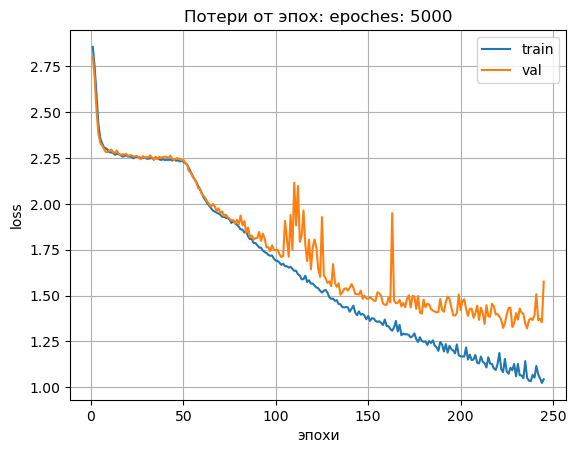

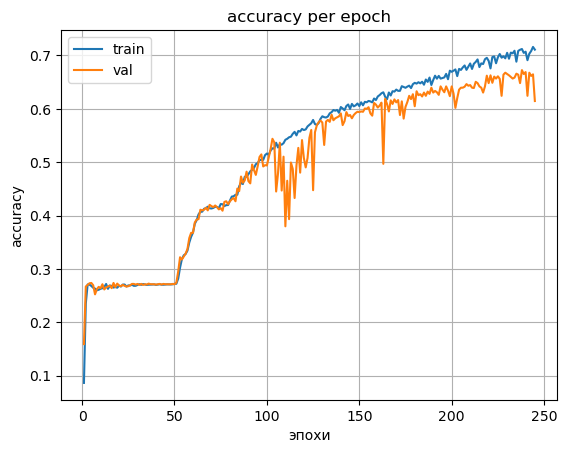

In [28]:
model = SurnameClassifier(
    embedding_dim = len(vocab_token_index),
    num_embeddings = 100,
    num_classes = len(vocab_index_nationality),
    rnn_hidden_size = 64,
    batch_first = True,
    padding_idx = 0
)

optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 10, factor=0.5, threshold=0.001, verbose=True)

model =\
training_loop(
    epoches = 5000,
    model = model,
    optimizer = optimizer,
    scheduler_append = False,
    scheduler = scheduler,
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    regulizer = False,
    reg_type = 'l1',
    stop_mode = True,
    each__X__epoch = 100,
    stop_diff_value = 0.001,
    verbose_epoch = 100
)